Hallo leute! Today’s post we will implement the awesome model to learn word embeddings Glove: Global Vectors for Word Representation, using Pytorch. Developed by Stanford, the main idea is to leverage the matrix of word cooccurrences in order to extract “dimensions of meaning”, outputing word vectors that naturally captures word semantics and thus being useful representations in a lot of tasks, such word analogies. You can find more information in the original paper here .

For this project, we will use the text8 dataset (that can be download here). This dataset is a dump of cleaned wikipedia texts. More details here .

First, we just import the necessary libs.

In [ ]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

Next we will create a dataset class to manage our feature extraction and batch generation. We must create a cooccurence matrix for every word to feed the glove model. We will generate a vocab of ~190k words. If we create a common matrix, it would have 190000² entries, which would result in ~36 billion entries. If we consider each value a 32bit integer, we are talking of ~135GB of memory, too much to store and process. To handle this issue we can leverage the fact that most of the entries of this matrix are 0 so we just need to store the non-zero values, which drastically reduce the amount of memory necessary.

Before Creating GLove dataset we will first create tokens array for our dataset

In [ ]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import re
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'\(\)\[\]\{\}\*\%\^\+\-\=\<\>\|(//)(\n)(\t)~]''')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                token_match=None)

spacy_que = spacy.load('en')
spacy_ans = spacy.load('en')
spacy_ans.tokenizer = custom_tokenizer(spacy_ans)

def tokenize_que(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_que.tokenizer(text)]

def tokenize_ans(text):
    """
    Tokenizes Code text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ans.tokenizer(text)]

train_lines = set([])
data = {"questions": "", "answers": ""}

with open('./english_python_data.txt', 'r') as f:
    for l in f:
        if l.startswith('# write'):
            data['questions'] = data['questions'].rstrip('\n')
            data['questions'] = data['questions'].lstrip('#')
            data['questions'] = data['questions'].lstrip()
            data['questions'] = data['questions'].rstrip()
            data['answers'] = data['answers'].rstrip('\n')
            train_lines.update(set(tokenize_ans(data['answers'])))
            data = {"questions": l, "answers": ""}
        else:
            if not l == '\n':
                data['answers'] = data['answers'] + l

train_lines = list(train_lines)
print('Number of unique tokens:', len(train_lines))

Number of unique tokens: 5651


In [ ]:
b = []

for k, v in enumerate(train_lines):
    if " " in v:
        b.append(k)

b.reverse()

for i in b:
    train_lines = train_lines[:i] + train_lines[i+1 :]

In [ ]:
class GloveDataset:

  def __init__(self, tokens, n_words=10000, window_size=5):
      self._window_size = window_size
      self._tokens = tokens
      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

  def _create_coocurrence_matrix(self):
      cooc_mat = defaultdict(Counter)
      for i, w in enumerate(self._id_tokens):
          start_i = max(i - self._window_size, 0)
          end_i = min(i + self._window_size + 1, len(self._id_tokens))
          for j in range(start_i, end_i):
              if i != j:
                  c = self._id_tokens[j]
                  cooc_mat[w][c] += 1 / abs(j-i)

      self._i_idx = list()
      self._j_idx = list()
      self._xij = list()

      #Create indexes and x values tensors
      for w, cnt in cooc_mat.items():
          for c, v in cnt.items():
              self._i_idx.append(w)
              self._j_idx.append(c)
              self._xij.append(v)

      self._i_idx = torch.LongTensor(self._i_idx) #.cuda()
      self._j_idx = torch.LongTensor(self._j_idx) #.cuda()
      self._xij = torch.FloatTensor(self._xij) #.cuda()


  def get_batches(self, batch_size):
      #Generate random idx
      rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

      for p in range(0, len(rand_ids), batch_size):
          batch_ids = rand_ids[p:p+batch_size]
          yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

dataset = GloveDataset(train_lines, 10000)

# of words: 5646
Vocabulary length: 5646


In [ ]:
dataset._word2id['hello']
dataset._id2word[421]

'roundrobin'

Here we create the class of our glove model. In its forward pass it will perform the yellow part of the Glove loss function, described in the original paper:

![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152473299/6HedPZypj.png?auto=compress)


In [ ]:
EMBED_DIM = 300
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
# glove.cuda()

We must define a function to compute the weighting term f(Xij) of the loss function as per described in the paper:


![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152743199/bjCyXW0Wc.png?auto=compress)


In [ ]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx #.cuda()

The loss function described in the Glove paper is a weighted mean squared error. Pytorch 1.0 doesn’t have implementation for it, so we must write it ourselves. A good practice is to reuse any piece of this function already implemented so we take advantage of any optimization it might have:

In [ ]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss) #.cuda()

Although we are using a diferent configuration (like the dataset) of the original paper, we will use the same optimizer and learning rate it describes.

In [ ]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)

Now we can write our training loop. The ALPHA and X_MAX parameters are set accoring to the paper. We also save our model states every 100 epochs.

In [ ]:
N_EPOCHS = 100
BATCH_SIZE = 1024
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 50 == 0:
            print("Epoch: {:3d}/{:3d} \t Batch: {:3}/{:3} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

torch.save(glove.state_dict(), "python_code_glove_embedding_300.pt")

Epoch:   1/100 	 Batch:  50/ 55 	 Loss: 0.5744187384843826
Epoch:   2/100 	 Batch:  50/ 55 	 Loss: 0.37917733043432233
Epoch:   3/100 	 Batch:  50/ 55 	 Loss: 0.04613669067621231
Epoch:   4/100 	 Batch:  50/ 55 	 Loss: 0.012395351752638816
Epoch:   5/100 	 Batch:  50/ 55 	 Loss: 0.004408300330396742
Epoch:   6/100 	 Batch:  50/ 55 	 Loss: 0.0017147345293778925
Epoch:   7/100 	 Batch:  50/ 55 	 Loss: 0.0007211532836663536
Epoch:   8/100 	 Batch:  50/ 55 	 Loss: 0.00041199250263161956
Epoch:   9/100 	 Batch:  50/ 55 	 Loss: 0.00016110887663671746
Epoch:  10/100 	 Batch:  50/ 55 	 Loss: 9.179254757327727e-05
Epoch:  11/100 	 Batch:  50/ 55 	 Loss: 4.85947470224346e-05
Epoch:  12/100 	 Batch:  50/ 55 	 Loss: 2.5890640790748877e-05
Epoch:  13/100 	 Batch:  50/ 55 	 Loss: 1.4457082534136134e-05
Epoch:  14/100 	 Batch:  50/ 55 	 Loss: 1.0971433357553906e-05
Epoch:  15/100 	 Batch:  50/ 55 	 Loss: 5.257394565205686e-06
Epoch:  16/100 	 Batch:  50/ 55 	 Loss: 5.747694561364369e-06
Epoch:  17/10

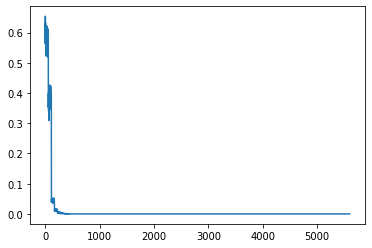

In [ ]:
plt.plot(loss_values)

Here we sum over the two embedding matrices (as per recommendation of the original paper) to improve results. We then plot the TSNE space of the top 300 words to validate our word embeddings.

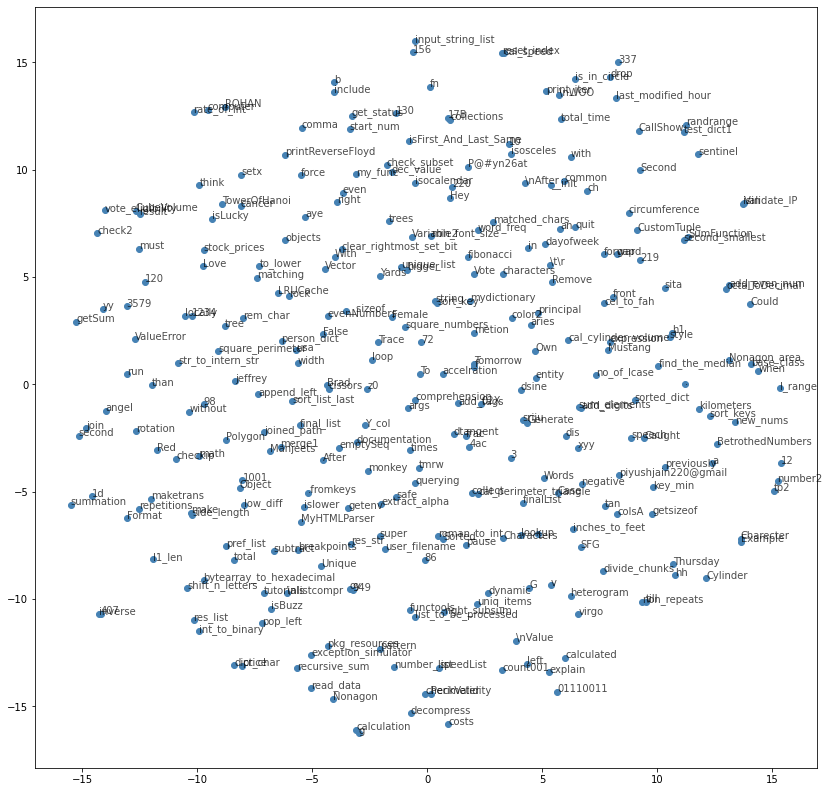

In [ ]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

Checking the words that are close, we can say that our model performs pretty good! We can check that it clusters the direction words north, south, west, east and even central. It also clusters together words with their plural form like system/systems and language/languages.

In [ ]:
lemb = emb.tolist()

for i, iemb in enumerate(lemb):
    iemb.insert(0, dataset._id2word[i])

nemb = np.array(lemb)

In [ ]:
np.savetxt('python_code_glove_embedding_300.txt', nemb, fmt='%s')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/python_code_glove_embedding_300.txt /content/drive/MyDrive/